In [5]:
import os
import pandas as pd
import numpy as np

In [6]:
csv_path = '1m_intraday_data.csv'
df = pd.read_csv(csv_path)

In [7]:
df.head()

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,1636119000,0.0,2021-11-05 13:30:00,16411.96680,16411.96680,16402.48828,16411.96680,NaN
1,1636119060,0.0,2021-11-05 13:31:00,16411.25195,16423.87500,16411.25195,16422.00000,37467190.0
2,1636119120,0.0,2021-11-05 13:32:00,16423.39648,16425.77344,16423.39648,16425.29297,5731554.0
3,1636119180,0.0,2021-11-05 13:33:00,16429.16016,16432.37891,16422.66602,16423.08398,5361080.0
4,1636119240,0.0,2021-11-05 13:34:00,16421.38867,16426.16602,16418.31250,16418.31250,5081066.0


In [8]:
df.index = df['Datetime']
df.head()

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
Datetime,,,,,,,,
2021-11-05 13:30:00,1636119000,0.0,2021-11-05 13:30:00,16411.96680,16411.96680,16402.48828,16411.96680,NaN
2021-11-05 13:31:00,1636119060,0.0,2021-11-05 13:31:00,16411.25195,16423.87500,16411.25195,16422.00000,37467190.0
2021-11-05 13:32:00,1636119120,0.0,2021-11-05 13:32:00,16423.39648,16425.77344,16423.39648,16425.29297,5731554.0
2021-11-05 13:33:00,1636119180,0.0,2021-11-05 13:33:00,16429.16016,16432.37891,16422.66602,16423.08398,5361080.0
2021-11-05 13:34:00,1636119240,0.0,2021-11-05 13:34:00,16421.38867,16426.16602,16418.31250,16418.31250,5081066.0


<AxesSubplot:xlabel='Datetime'>

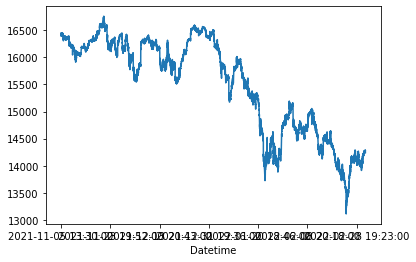

In [9]:
close_data = df['Close']
close_data.plot()

In [10]:
print(close_data)

Datetime
2021-11-05 13:30:00    16411.96680
2021-11-05 13:31:00    16422.00000
2021-11-05 13:32:00    16425.29297
2021-11-05 13:33:00    16423.08398
2021-11-05 13:34:00    16418.31250
                          ...     
2022-03-02 20:56:00    14260.94434
2022-03-02 20:57:00    14250.83301
2022-03-02 20:58:00    14246.97852
2022-03-02 20:59:00    14244.31543
NaN                            NaN
Name: Close, Length: 30878, dtype: float64


In [11]:
def data_into_difference(df):
    df = df.to_numpy()
    differences = []
    for i in range(1, len(df)):
        differences.append(df[i] - df[i - 1])

    
    return differences
new_data = data_into_difference(close_data)


In [12]:
def df_to_X_y(df, window_size= 180):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 180
X, y = df_to_X_y(new_data, WINDOW_SIZE)
X.shape, y.shape
print(X)

[[[ 10.0332 ]
  [  3.29297]
  [ -2.20899]
  ...
  [ -5.58008]
  [  3.40821]
  [  5.73828]]

 [[  3.29297]
  [ -2.20899]
  [ -4.77148]
  ...
  [  3.40821]
  [  5.73828]
  [ -4.26172]]

 [[ -2.20899]
  [ -4.77148]
  [ 21.77344]
  ...
  [  5.73828]
  [ -4.26172]
  [  7.84961]]

 ...

 [[ -3.06836]
  [ -2.07226]
  [  9.77246]
  ...
  [-21.00586]
  [ -1.39453]
  [-10.11133]]

 [[ -2.07226]
  [  9.77246]
  [ 11.51172]
  ...
  [ -1.39453]
  [-10.11133]
  [ -3.85449]]

 [[  9.77246]
  [ 11.51172]
  [  2.0498 ]
  ...
  [-10.11133]
  [ -3.85449]
  [ -2.66309]]]


In [13]:
X_train, y_train = X[:28000], y[:28000]
X_val, y_val = X[28000:29000], y[28000:29000]
X_test, y_test = X[29000], y[29000]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28000, 60, 1), (28000,), (1000, 60, 1), (1000,), (60, 1), ())

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((180, 1)))
model1.add(LSTM(64))
model1.add(Dense(64, 'relu'))
model1.add(Dense(64, 'relu'))
model1.add(Dense(64, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('modelNDQ/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [23]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/5
875/875 [==============================] - ETA: 0s - loss: 133.6885 - root_mean_squared_error: 11.5624

INFO:tensorflow:Assets written to: modelNDQ\assets


INFO:tensorflow:Assets written to: modelNDQ\assets


875/875 [==============================] - 17s 18ms/step - loss: 133.6885 - root_mean_squared_error: 11.5624 - val_loss: 361.0126 - val_root_mean_squared_error: 19.0003
Epoch 2/5
875/875 [==============================] - ETA: 0s - loss: 133.7953 - root_mean_squared_error: 11.5670

INFO:tensorflow:Assets written to: modelNDQ\assets


INFO:tensorflow:Assets written to: modelNDQ\assets


875/875 [==============================] - 16s 18ms/step - loss: 133.7953 - root_mean_squared_error: 11.5670 - val_loss: 359.6207 - val_root_mean_squared_error: 18.9637
Epoch 3/5
875/875 [==============================] - 11s 13ms/step - loss: 133.6100 - root_mean_squared_error: 11.5590 - val_loss: 360.1649 - val_root_mean_squared_error: 18.9780
Epoch 4/5
872/875 [============================>.] - ETA: 0s - loss: 133.7862 - root_mean_squared_error: 11.5666

INFO:tensorflow:Assets written to: modelNDQ\assets


INFO:tensorflow:Assets written to: modelNDQ\assets


875/875 [==============================] - 15s 17ms/step - loss: 133.7210 - root_mean_squared_error: 11.5638 - val_loss: 359.3511 - val_root_mean_squared_error: 18.9566
Epoch 5/5
875/875 [==============================] - 11s 13ms/step - loss: 133.5507 - root_mean_squared_error: 11.5564 - val_loss: 359.6460 - val_root_mean_squared_error: 18.9643


In [17]:
from tensorflow.keras.models import load_model
model1 = load_model('modelNDQ/')

In [18]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

875/875 [==============================] - 5s 6ms/step


,Train Predictions,Actuals
0,0.582791,-4.26172
1,-0.803383,7.84961
2,0.906684,-2.89844
3,-0.706853,0.27344
4,-0.199709,-4.92774
...,...,...
27995,1.193066,4.22461
27996,-0.009147,3.97754
27997,0.058495,0.52636
27998,-0.420176,0.04200


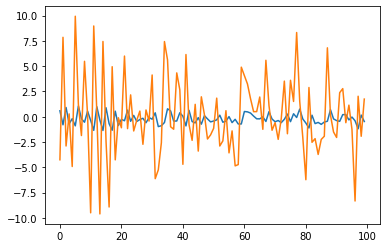

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][0:100], )
plt.plot(train_results['Actuals'][0:100])

In [ ]:
import keras
keras.__version__

'2.9.0'

43/43 [==============================] - 0s 2ms/step


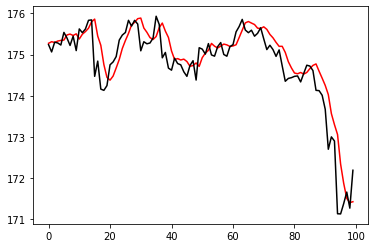

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test} )

plt.plot(test_results['Test Predictions'][:100],color='red')
plt.plot(test_results['Actuals'][:100] ,color='black')

In [ ]:
X_final = X[6359:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape